# Tennis Action Evaluator

## Introduction

### Problem

### Model Definition

#### State

#### Action

#### Rewards

### Data Processing

#### Raw Data

#### Extracted data

### Evaluation

We evaluate the model based on how well it estimates the actual probability that the agent at state $s$ performing action $a$ will win the rally.

We do this by passing a list of $(s,a)$ pairs to the estimator model to get the $Q(s,a)$ indicating the probability of the agent winning. Each $(s,a)$ pair has already been marked as belonging to the winner or the loser of the rally.

We deem a prediction correct in the following cases:
1. The $(s,a)$ pair belongs to the winner and gives a $Q(s,a) \ge 0.5$ 
2. The $(s,a)$ pair belongs to the loser and gives a $Q(s,a) \lt 0.5$

The final score of the model is calculated using $\frac{\text{correct predictions}}{\text{total predictions}}$.

## Approximated MC Learning

First, we tried a simple approximated MC learning to approximate the $Q(s,a)$ function as a baseline. This is a simple linear regression problem. We used `sklearn.linear_model.LinearRegression` to create an estimator model.

Since the reward of a tennis rally is only non-zero at the end of a rally, MC learning's behavior of looking at the accumulated rewards for an entire trial might be beneficial for estimating the Q-values of tennis actions.

### Training

Being that it is merely solving a system of linear equations, training of the estimator model is very quick for approximated MC learning.

In [1]:
import mc_learning as mc

mc_model = mc.train(save=False)
print(mc_model.coef_)

[[ 0.00046365  0.00620755  0.00934649 -0.02493163  0.0050135  -0.02148365
  -0.00191497 -0.00411411 -0.00643848  0.0220249  -0.00568214  0.02426598
   0.00129729 -0.00062967 -0.02203004  0.00634108 -0.00288176]]


### Evaluation

However, accuracy is low for this method, only correctly predicting the outcome of the $Q(s,a)$ correctly 53% of the time. The $Q(s,a)$ cannot be directly represented by a linear function of the features we have defined.

In [2]:
from data import test_dataset
import evaluation as eval

def mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = mc_model.predict(single_sample_reshape)
    return pred

score = eval.score_model(test_dataset, mc_predict)

print(f"Linear MC Learning Accuracy: {score}")

Linear MC Learning Accuracy: (0.5361596009975063, 0.24950967844844793)


## Deep Reinforcement Learning

### MC

#### Training

In [3]:
import d_sarsa

nn_mc_model, nn_mc_report = d_sarsa.train(save=False, use_mc=True)

EPOCH: 1.000  train_ave_loss: 0.255  train_ave_acc: 0.549  (3.15s - 625.93s remaining) ave_loss: 0.25530052279010196 ave_acc: 0.549278882548325
EPOCH: 2.000  train_ave_loss: 0.245  train_ave_acc: 0.584  (6.18s - 611.61s remaining) ave_loss: 0.24485115840200805 ave_acc: 0.5842291205885796
EPOCH: 3.000  train_ave_loss: 0.240  train_ave_acc: 0.600  (9.16s - 601.81s remaining) ave_loss: 0.24049882188745259 ave_acc: 0.5997931522828697
EPOCH: 4.000  train_ave_loss: 0.235  train_ave_acc: 0.610  (12.28s - 601.90s remaining) ave_loss: 0.23526452808938592 ave_acc: 0.6099242879136506
EPOCH: 5.000  train_ave_loss: 0.229  train_ave_acc: 0.620  (15.36s - 599.10s remaining) ave_loss: 0.22873368049777848 ave_acc: 0.6198057336986034
EPOCH: 6.000  train_ave_loss: 0.225  train_ave_acc: 0.615  (18.45s - 596.62s remaining) ave_loss: 0.22535698526317685 ave_acc: 0.614502499162566
EPOCH: 7.000  train_ave_loss: 0.221  train_ave_acc: 0.631  (21.41s - 590.19s remaining) ave_loss: 0.22143548967376833 ave_acc: 0.

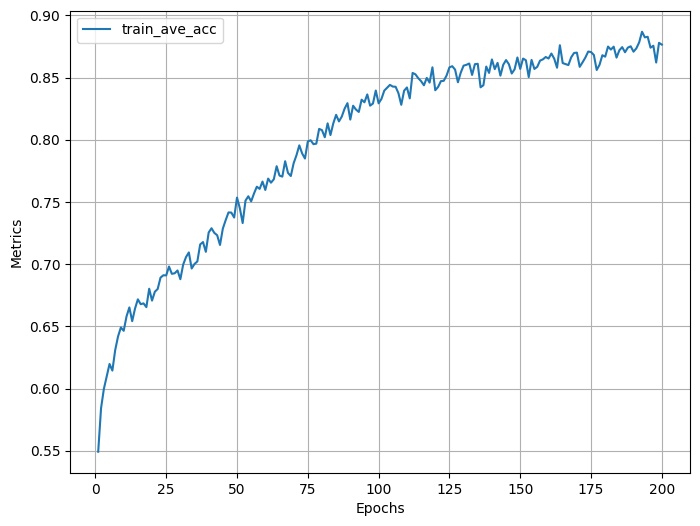

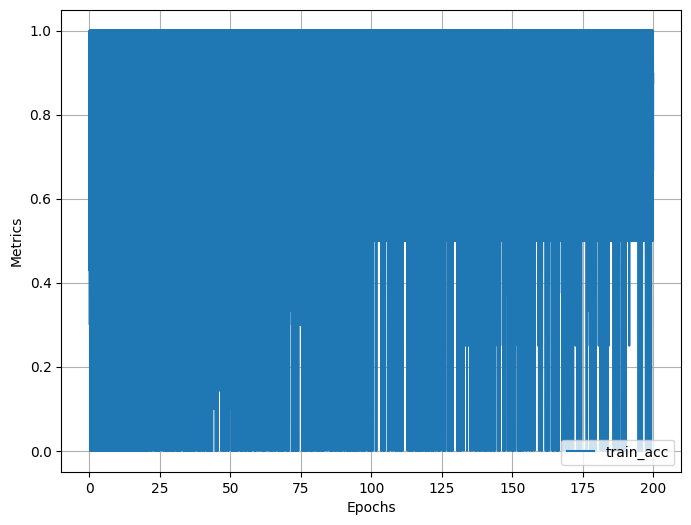

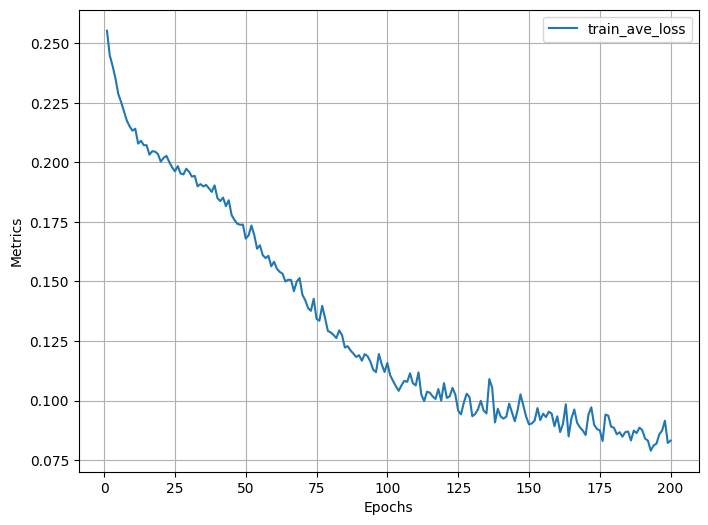

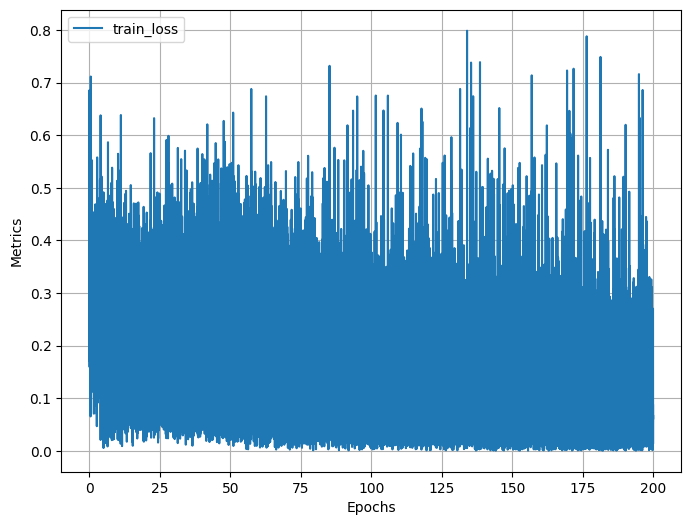

In [4]:
nn_mc_report.plot('train_ave_acc')
nn_mc_report.plot('train_acc')
nn_mc_report.plot('train_ave_loss')
nn_mc_report.plot('train_loss')

#### Evaluation

In [5]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_mc_model.eval()
def nn_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_mc_score, nn_mc_mse = eval.score_model(test_dataset, nn_mc_predict)

def nn_mc_predict_seq(sa_pair_seq):
    pred = nn_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_mc_seq_score, nn_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_mc_predict_seq)

print(f"NN MC Accuracy: {nn_mc_score}")
print(f"NN MC MSE: {nn_mc_mse}")
print(f"NN MC Seq Accuracy: {nn_mc_seq_score}")
print(f"NN MC Seq MSE: {nn_mc_seq_mse}")

NN MC Accuracy: 0.5660847880299252
NN MC MSE: 0.31505615191109937
NN MC Seq Accuracy: 0.5847880299251871
NN MC Seq MSE: 0.3377837085942867


### SARSA

#### Training (Without MC Init)

In [6]:
import d_sarsa

nn_sarsa_model, nn_sarsa_report = d_sarsa.train(save=False, use_mc=False)

EPOCH: 1.000  train_ave_loss: 0.177  train_ave_acc: 0.510  (2.91s - 579.03s remaining) ave_loss: 0.1774514167626932 ave_acc: 0.5095622356455433
EPOCH: 2.000  train_ave_loss: 0.146  train_ave_acc: 0.523  (5.61s - 555.57s remaining) ave_loss: 0.14573270987031048 ave_acc: 0.5230660513321803
EPOCH: 3.000  train_ave_loss: 0.149  train_ave_acc: 0.515  (8.35s - 548.37s remaining) ave_loss: 0.14915441835839902 ave_acc: 0.5146275420503582
EPOCH: 4.000  train_ave_loss: 0.138  train_ave_acc: 0.521  (11.76s - 576.16s remaining) ave_loss: 0.13761951147832654 ave_acc: 0.5213810969942889
EPOCH: 5.000  train_ave_loss: 0.135  train_ave_acc: 0.525  (14.89s - 580.63s remaining) ave_loss: 0.13461077725105097 ave_acc: 0.524587557213927
EPOCH: 6.000  train_ave_loss: 0.132  train_ave_acc: 0.539  (17.86s - 577.50s remaining) ave_loss: 0.13160647216452356 ave_acc: 0.5390731998284912
EPOCH: 7.000  train_ave_loss: 0.120  train_ave_acc: 0.560  (20.69s - 570.48s remaining) ave_loss: 0.12001799834657274 ave_acc: 0.

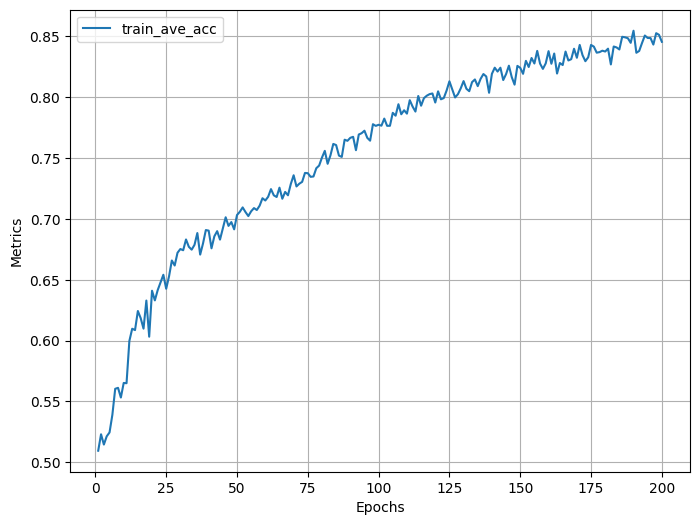

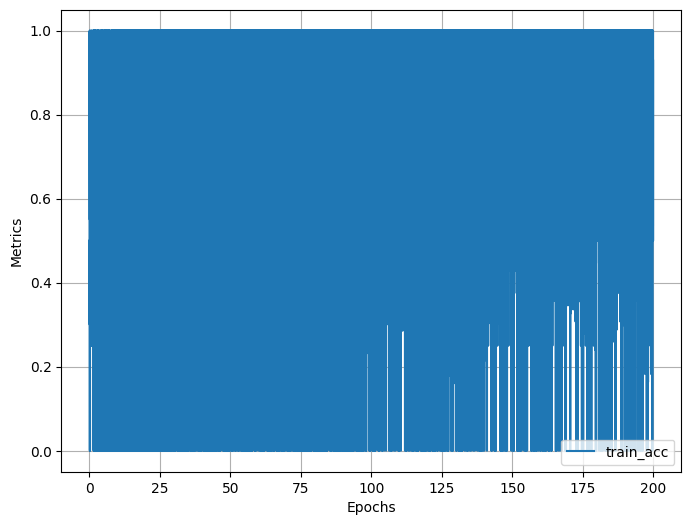

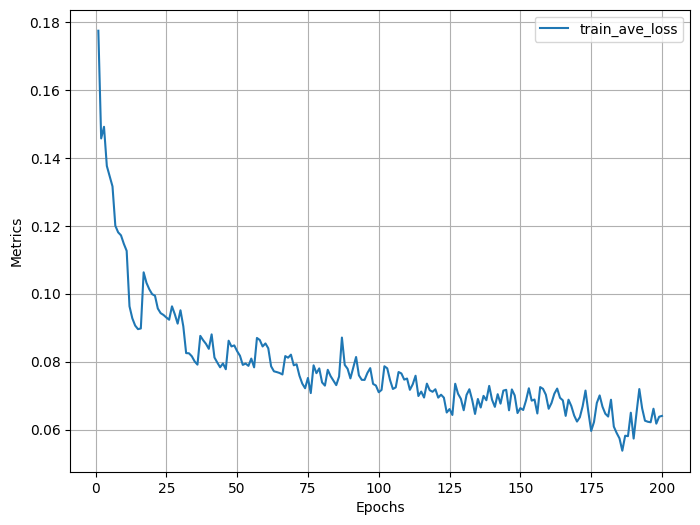

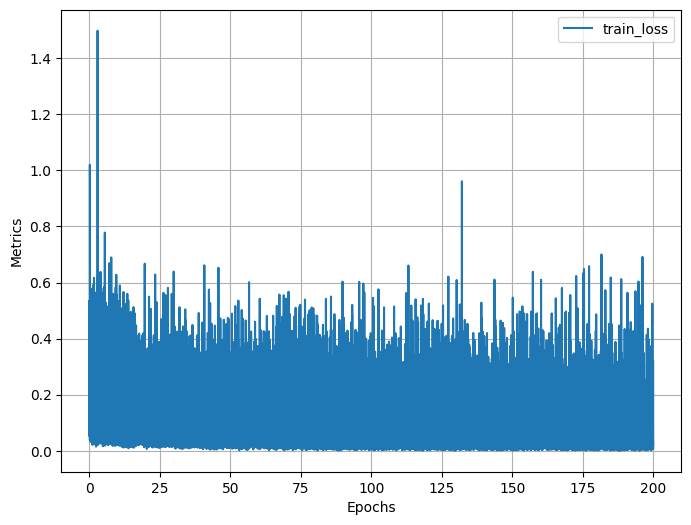

In [7]:
nn_sarsa_report.plot('train_ave_acc')
nn_sarsa_report.plot('train_acc')
nn_sarsa_report.plot('train_ave_loss')
nn_sarsa_report.plot('train_loss')

#### Evaluation (Without MC Init)

In [8]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_model.eval()
def nn_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_score, nn_sarsa_mse = eval.score_model(test_dataset, nn_predict)

def nn_predict_seq(sa_pair_seq):
    pred = nn_sarsa_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_seq_score, nn_sarsa_seq_mse = eval.score_model_sequential(test_dataset, nn_predict_seq)

print(f"NN Sarsa Accuracy: {nn_sarsa_score}")
print(f"NN Sarsa MSE: {nn_sarsa_mse}")
print(f"NN Sarsa Seq Accuracy: {nn_sarsa_seq_score}")
print(f"NN Sarsa Seq MSE: {nn_sarsa_seq_mse}")

NN Sarsa Accuracy: 0.557356608478803
NN Sarsa MSE: 0.29458099199807025
NN Sarsa Seq Accuracy: 0.628428927680798
NN Sarsa Seq MSE: 0.26588374356718414


#### Training (With MC Init)

In [9]:
import d_sarsa

mc_init_epochs = 50
sarsa_epochs = 200

print("MC INIT TRAINING")
nn_sarsa_with_mc_mc_model, nn_sarsa_with_mc_mc_report = d_sarsa.train(save=False, use_mc=False, num_epochs=mc_init_epochs)

print("SARASA WITH MC INIT TRAINING")
nn_mc_state_dict = nn_sarsa_with_mc_mc_model.state_dict()
nn_sarsa_with_mc_model, nn_sarsa_with_mc_report = d_sarsa.train(save=False, use_mc=False, init_state_dict=nn_mc_state_dict, num_epochs=sarsa_epochs)

MC INIT TRAINING
EPOCH: 1.000  train_ave_loss: 0.171  train_ave_acc: 0.503  (3.14s - 153.69s remaining) ave_loss: 0.17078615126372082 ave_acc: 0.5025521602867644
EPOCH: 2.000  train_ave_loss: 0.145  train_ave_acc: 0.517  (7.38s - 177.19s remaining) ave_loss: 0.14537626332835543 ave_acc: 0.5169821724026599
EPOCH: 3.000  train_ave_loss: 0.142  train_ave_acc: 0.530  (11.04s - 172.94s remaining) ave_loss: 0.14212755003228478 ave_acc: 0.5297977165600057
EPOCH: 4.000  train_ave_loss: 0.137  train_ave_acc: 0.532  (13.85s - 159.24s remaining) ave_loss: 0.136673852550057 ave_acc: 0.5315544308233703
EPOCH: 5.000  train_ave_loss: 0.134  train_ave_acc: 0.544  (16.61s - 149.49s remaining) ave_loss: 0.1343431630311124 ave_acc: 0.543512765465511
EPOCH: 6.000  train_ave_loss: 0.135  train_ave_acc: 0.532  (19.29s - 141.43s remaining) ave_loss: 0.134829909778323 ave_acc: 0.53152838766684
EPOCH: 7.000  train_ave_loss: 0.122  train_ave_acc: 0.564  (22.59s - 138.77s remaining) ave_loss: 0.12205357457950843

MC INIT PLOTS


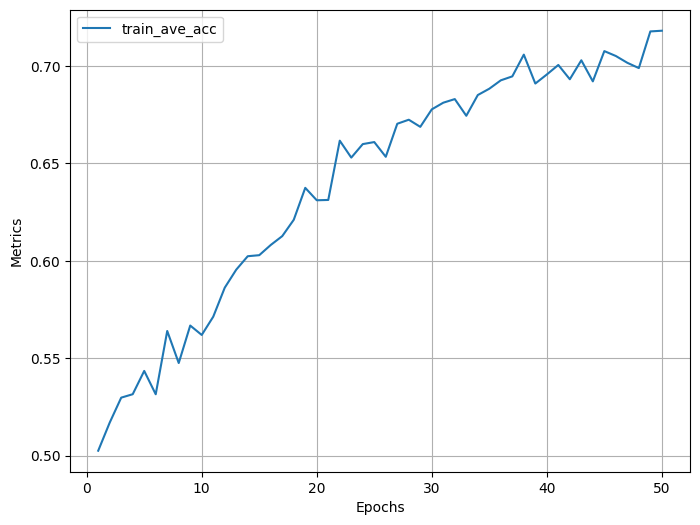

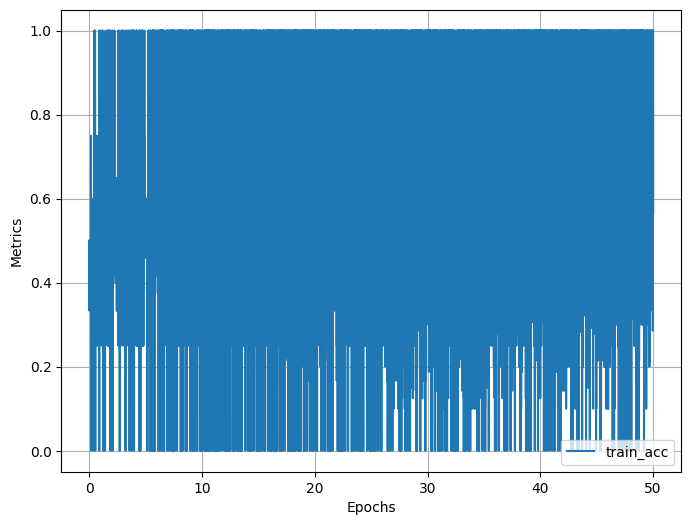

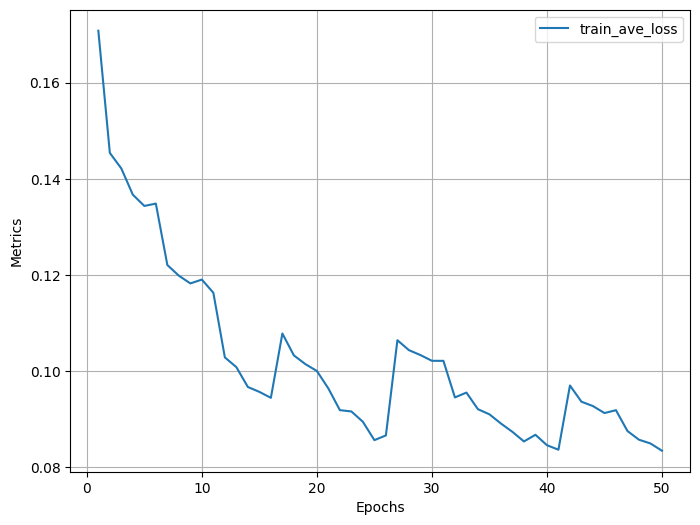

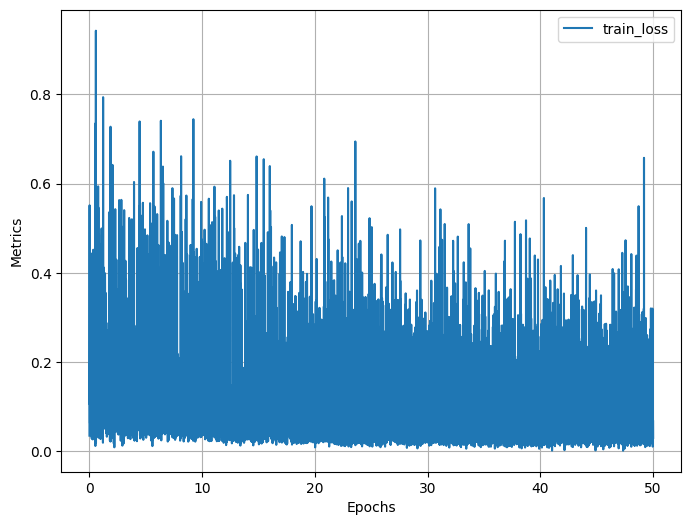

SARSA WITH MC INIT PLOTS


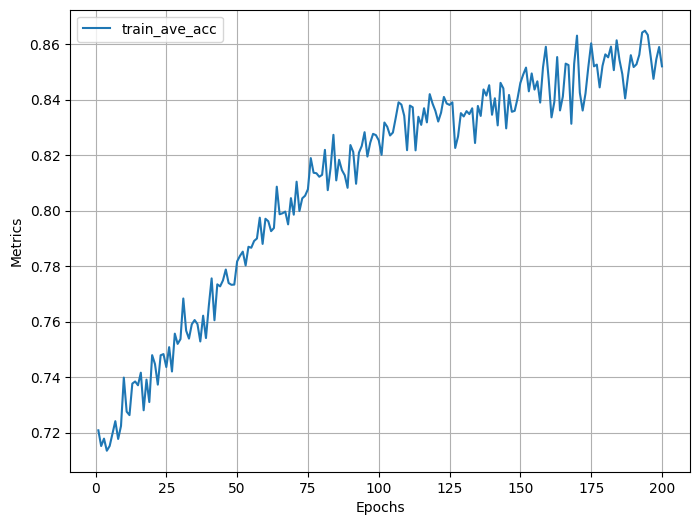

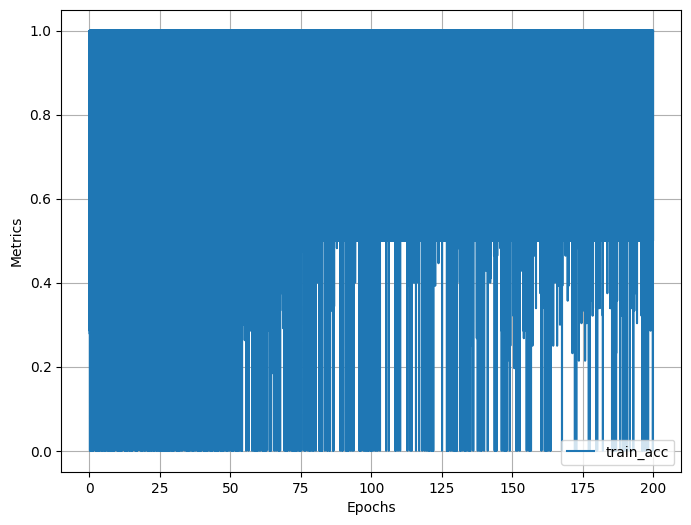

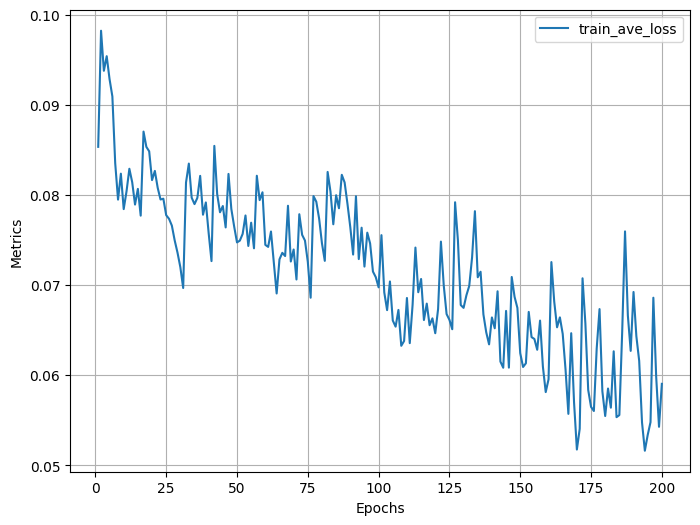

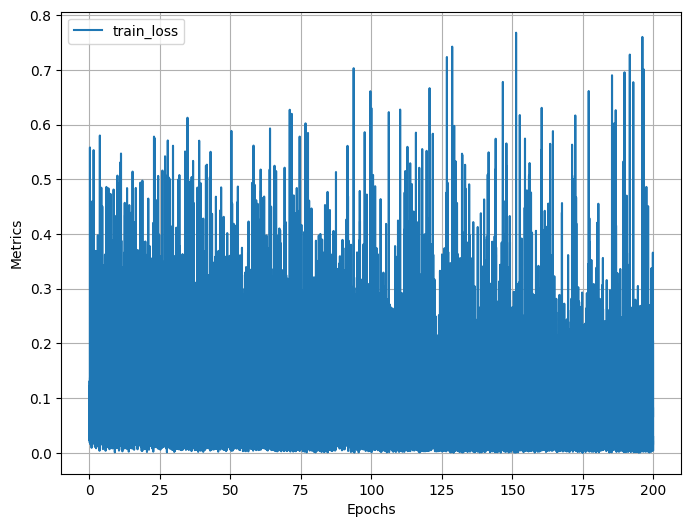

In [10]:
print("MC INIT PLOTS")
nn_sarsa_with_mc_mc_report.plot('train_ave_acc')
nn_sarsa_with_mc_mc_report.plot('train_acc')
nn_sarsa_with_mc_mc_report.plot('train_ave_loss')
nn_sarsa_with_mc_mc_report.plot('train_loss')

print("SARSA WITH MC INIT PLOTS")
nn_sarsa_with_mc_report.plot('train_ave_acc')
nn_sarsa_with_mc_report.plot('train_acc')
nn_sarsa_with_mc_report.plot('train_ave_loss')
nn_sarsa_with_mc_report.plot('train_loss')

#### Evaluation (With MC Init)

In [11]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_with_mc_mc_model.eval()
def nn_sarsa_with_mc_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_with_mc_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_with_mc_mc_score, nn_sarsa_with_mc_mc_mse = eval.score_model(test_dataset, nn_sarsa_with_mc_mc_predict)

def nn_sarsa_with_mc_mc_predict_seq(sa_pair_seq):
    pred = nn_sarsa_with_mc_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_with_mc_mc_seq_score, nn_sarsa_with_mc_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_sarsa_with_mc_mc_predict_seq)

nn_sarsa_with_mc_model.eval()
def nn_sarsa_with_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_with_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_with_mc_score, nn_sarsa_with_mc_mse = eval.score_model(test_dataset, nn_sarsa_with_mc_predict)

def nn_sarsa_with_mc_predict_seq(sa_pair_seq):
    pred = nn_sarsa_with_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_with_mc_seq_score, nn_sarsa_with_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_sarsa_with_mc_predict_seq)

print("MC INIT EVALS")
print(f"NN MC Init Accuracy: {nn_sarsa_with_mc_mc_score}")
print(f"NN MC Init MSE: {nn_sarsa_with_mc_mc_mse}")
print(f"NN MC Init Seq Accuracy: {nn_sarsa_with_mc_mc_seq_score}")
print(f"NN MC Init Seq MSE: {nn_sarsa_with_mc_mc_seq_mse}")

print("SARSA WITH MC INIT EVALS")
print(f"NN Sarsa With MC Init Accuracy: {nn_sarsa_with_mc_score}")
print(f"NN Sarsa With MC Init MSE: {nn_sarsa_with_mc_mse}")
print(f"NN Sarsa With MC Init Seq Accuracy: {nn_sarsa_with_mc_seq_score}")
print(f"NN Sarsa With MC Init Seq MSE: {nn_sarsa_with_mc_seq_mse}")

MC INIT EVALS
NN MC Init Accuracy: 0.5660847880299252
NN MC Init MSE: 0.2637854348370989
NN MC Init Seq Accuracy: 0.5760598503740648
NN MC Init Seq MSE: 0.2444442796443436
SARSA WITH MC INIT EVALS
NN Sarsa With MC Init Accuracy: 0.5810473815461347
NN Sarsa With MC Init MSE: 0.30504056376096783
NN Sarsa With MC Init Seq Accuracy: 0.5947630922693267
NN Sarsa With MC Init Seq MSE: 0.3007700027787876


In [12]:
import os

model_dirpath = 'experiment_models/controlled_mc_200epoch_e-3lr_vanilla_paper_params'
os.makedirs(model_dirpath, exist_ok=True)


torch.save(nn_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_mc_model.pth'))
torch.save(nn_sarsa_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_model.pth'))
torch.save(nn_sarsa_with_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_with_mc_model.pth'))

## Conclusion

### Summary

### Future extensions